# ML MINIONS

An XGBoost model to predict crop yield

### Libraries

In [1]:
# for target encoding
!pip install --upgrade category_encoders xgboost

In [2]:
import numpy as np
import pandas as pd

# for target encoding
import category_encoders as ce

# train test split
from sklearn.model_selection import train_test_split

# model
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error

In [3]:
try:
    df = pd.read_csv('crop_yield.csv')
    print("Successfully loaded crop_yield.csv")
    print("Dataset shape:", df.shape)
    print("Dataset preview:")
    print(df.head())
except FileNotFoundError:
    print("Error: 'crop_yield.csv' not found. Please make sure the file is in the correct directory.")
    exit()

Successfully loaded crop_yield.csv
Dataset shape: (19689, 10)
Dataset preview:
           Crop  Crop_Year       Season  State     Area  Production  \
0      Arecanut       1997  Whole Year   Assam  73814.0       56708   
1     Arhar/Tur       1997  Kharif       Assam   6637.0        4685   
2   Castor seed       1997  Kharif       Assam    796.0          22   
3      Coconut        1997  Whole Year   Assam  19656.0   126905000   
4  Cotton(lint)       1997  Kharif       Assam   1739.0         794   

   Annual_Rainfall  Fertilizer  Pesticide        Yield  
0           2051.4  7024878.38   22882.34     0.796087  
1           2051.4   631643.29    2057.47     0.710435  
2           2051.4    75755.32     246.76     0.238333  
3           2051.4  1870661.52    6093.36  5238.051739  
4           2051.4   165500.63     539.09     0.420909  


### Data Preprocessing

In [4]:
df['Fertilizer_per_Area'] = df['Fertilizer'] / (df['Area'] + 1e-6)
df['Pesticide_per_Area'] = df['Pesticide'] / (df['Area'] + 1e-6)
df = df[df['Crop'] != 'Coconut '] # skewed problematic

X = df.drop(['Yield', 'Production', 'Area', 'Fertilizer', 'Pesticide'], axis=1)
y = df['Yield']

In [5]:
X.head()

,Crop,Crop_Year,Season,State,Annual_Rainfall,Fertilizer_per_Area,Pesticide_per_Area
0,Arecanut,1997,Whole Year,Assam,2051.4,95.17,0.31
1,Arhar/Tur,1997,Kharif,Assam,2051.4,95.17,0.31
2,Castor seed,1997,Kharif,Assam,2051.4,95.17,0.31
4,Cotton(lint),1997,Kharif,Assam,2051.4,95.17,0.31
5,Dry chillies,1997,Whole Year,Assam,2051.4,95.17,0.31


In [6]:
y.head()

,Yield
0,0.796087
1,0.710435
2,0.238333
4,0.420909
5,0.643636


In [7]:
print(df.select_dtypes(include='object').nunique())
print("\nOriginal shape:", df.shape)

Crop      54
Season     6
State     30
dtype: int64

Original shape: (19517, 12)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (15613, 7)
Testing set shape: (3904, 7)


In [9]:
# Transform the target variable to a logarithmic scale
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

print("Original y_test sample:", y_test.head().values)
print("Log-transformed y_test sample:", y_test_log.head().values)

Original y_test sample: [0.98243243 0.78       2.12       0.52538461 0.637     ]
Log-transformed y_test sample: [0.68432459 0.57661336 1.137833   0.42224658 0.4928653 ]


### Feature Engineering

In [10]:
# for target encoding, the columns that have too many categories

target_cols = ['Crop', 'State']
encoder = ce.TargetEncoder(cols=target_cols, smoothing=10)
encoder.fit(X_train, y_train_log)

X_train_target_encoded = encoder.transform(X_train)
X_test_target_encoded = encoder.transform(X_test)

print("\nPreview of the data after Target Encoding:");
print(X_train_target_encoded.head())


Preview of the data after Target Encoding:
           Crop  Crop_Year       Season     State  Annual_Rainfall  \
3135   0.760791       2010  Rabi         1.015058           2578.5   
13445  0.718451       2013  Kharif       1.185713           1348.7   
16824  0.445162       2019  Kharif       1.101391            351.8   
7013   0.411932       1999  Summer       1.122310            883.4   
4069   0.597754       2013  Whole Year   1.221905            740.9   

       Fertilizer_per_Area  Pesticide_per_Area  
3135            166.110000                0.24  
13445           144.490000                0.27  
16824           171.759999                0.37  
7013            106.130000                0.27  
4069            144.490000                0.27  


In [11]:
# one-hot encoding the 'Season' column
all_seasons = df['Season'].unique().tolist()
print(f"Master list of all seasons: {all_seasons}")

# converting the 'Season' column into the different categories
X_train_target_encoded['Season'] = pd.Categorical(
    X_train_target_encoded['Season'],
    categories=all_seasons
)

X_test_target_encoded['Season'] = pd.Categorical(
    X_test_target_encoded['Season'],
    categories=all_seasons
)

# one-hot encoding
X_train_final = pd.get_dummies(X_train_target_encoded, columns=['Season'], dtype=int)
X_test_final = pd.get_dummies(X_test_target_encoded, columns=['Season'], dtype=int)

print("One-hot encoding applied. The 'Season' column has been replaced.")
print("\nPreview of the training data with new 'Season' columns:")
print(X_train_final.head())

Master list of all seasons: ['Whole Year ', 'Kharif     ', 'Rabi       ', 'Autumn     ', 'Summer     ', 'Winter     ']
One-hot encoding applied. The 'Season' column has been replaced.

Preview of the training data with new 'Season' columns:
           Crop  Crop_Year     State  Annual_Rainfall  Fertilizer_per_Area  \
3135   0.760791       2010  1.015058           2578.5           166.110000   
13445  0.718451       2013  1.185713           1348.7           144.490000   
16824  0.445162       2019  1.101391            351.8           171.759999   
7013   0.411932       1999  1.122310            883.4           106.130000   
4069   0.597754       2013  1.221905            740.9           144.490000   

       Pesticide_per_Area  Season_Whole Year   Season_Kharif       \
3135                 0.24                   0                   0   
13445                0.27                   0                   1   
16824                0.37                   0                   1   
7013          

### Defining the XGBoost model

In [12]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', # this is for minimizing the squared error
    n_estimators=2000, # number of decision trees in the ensemble (in sequence)
    learning_rate=0.3,
    early_stopping_rounds=50,
    seed = 59
)

print("XGBoost model initialized")

XGBoost model initialized


In [13]:
print("Training... (This may take a moment)")

eval_set = [(X_test_final, y_test_log,)]

xgb_model.fit(
    X_train_final,
    y_train_log,
    eval_set=eval_set,
    verbose=False
)

print("Model done training!")

Training... (This may take a moment)
Model done training!


### Evaluation

In [14]:
y_pred_train_log = xgb_model.predict(X_train_final)
y_pred_original_train = np.expm1(y_pred_train_log)

r2 = r2_score(y_train, y_pred_original_train)
mae = mean_absolute_error(y_train, y_pred_original_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_original_train))
medae = median_absolute_error(y_train, y_pred_original_train)

print("Final Model Performance on the Train Set:")
print(f"R-squared (R²): {r2:.4f}  (Explains {r2*100:.2f}% of the variance)")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Median Absolute Error (MedAE): {medae:.4f}")

Final Model Performance on the Train Set:
R-squared (R²): 0.9909  (Explains 99.09% of the variance)
Mean Absolute Error (MAE): 0.2198
Root Mean Squared Error (RMSE): 1.4338
Median Absolute Error (MedAE): 0.0671


In [15]:
y_pred_log = xgb_model.predict(X_test_final)
y_pred_original = np.expm1(y_pred_log)

r2 = r2_score(y_test, y_pred_original)
mae = mean_absolute_error(y_test, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_original))
medae = median_absolute_error(y_test, y_pred_original)


print("Final Model Performance on the Test Set")
print(f"R-squared (R²): {r2:.4f}  (Explains {r2*100:.2f}% of the variance)")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Median Absolute Error (MedAE): {medae:.4f}")

Final Model Performance on the Test Set
R-squared (R²): 0.9156  (Explains 91.56% of the variance)
Mean Absolute Error (MAE): 0.9661
Root Mean Squared Error (RMSE): 3.6518
Median Absolute Error (MedAE): 0.1770


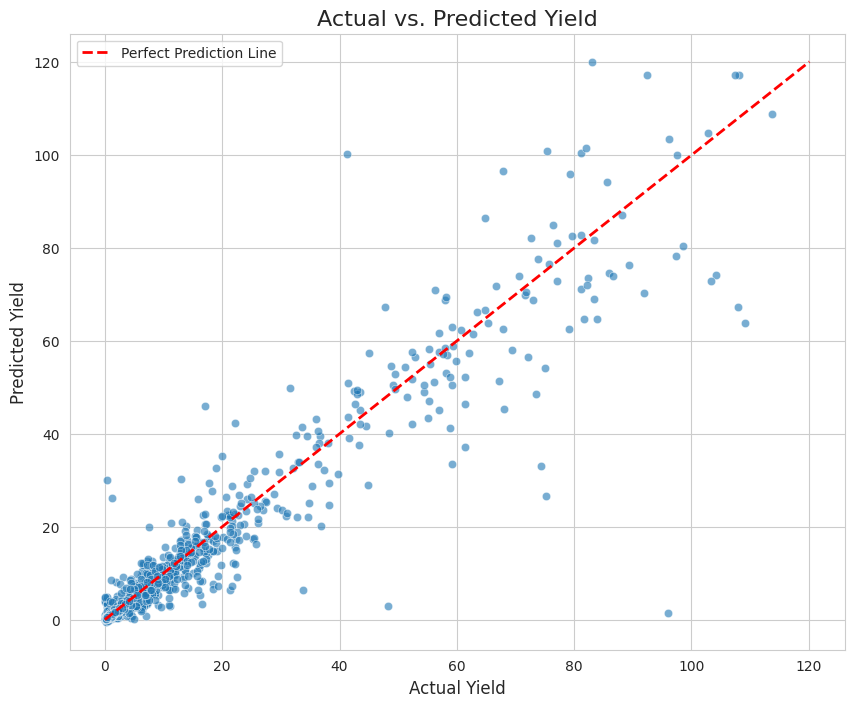

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=y_pred_original, alpha=0.6)

max_val = max(y_test.max(), y_pred_original.max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', lw=2, label='Perfect Prediction Line')

plt.title('Actual vs. Predicted Yield', fontsize=16)
plt.xlabel('Actual Yield', fontsize=12)
plt.ylabel('Predicted Yield', fontsize=12)
plt.legend()
plt.show()